In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import six

import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy import utils
from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

In [2]:
%matplotlib notebook

In [3]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [4]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.
df=pd.read_csv(os.path.join(bml_data_dir,'csv','NCK_wll_concatenated.csv'))
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
nck_wll=df.set_index('time')

nck_wll.head()

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,hour,minute,second,depth m,temp degC,Unnamed: 8
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,11.657694,13.846,NaN
2016-04-06 23:27:00,2016,4,6,23,27,0,11.656686,13.269,NaN
2016-04-06 23:30:00,2016,4,6,23,30,0,11.654668,12.980,NaN
2016-04-06 23:33:00,2016,4,6,23,33,0,11.652651,12.883,NaN
2016-04-06 23:36:00,2016,4,6,23,36,0,11.648617,12.787,NaN


In [5]:
# Load QCM data, too -- code taken from pesca_base.py
qcm_pre2016=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output.csv",                                                                     
                        skiprows=[0],usecols=range(7),                                                                                              
                        parse_dates=['Date (PST)'])                                                                                                 
qcm_2016_2017=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output_4.28.2021.csv",                                                         
                          skiprows=[0],usecols=range(14),                                                                                           
                          parse_dates=['Date (PST)'])                                                                                               
# some extra rows in the csv                                                                                                                        
qcm_2016_2017=qcm_2016_2017[ ~qcm_2016_2017['Date (PST)'].isnull() ]                                                                                
qcm=pd.concat([qcm_pre2016,qcm_2016_2017])                                                                                                          

qcm['time']=qcm['Date (PST)'] + np.timedelta64(8,'h') # Shift to UTC.                                                        
# These are both NAVD88, converted ft=>m                                                                                                            
# Prefer the modified data when available:                                                                                                          
ocean_modified=qcm['Modified Ocean Level (feet NAVD88)']                                                                                            
# Otherwise the observed data.                                                                                                                      
ocean_level=qcm['Ocean level (feet NAVD88)']                                                                                                        
qcm['z_ocean']=0.3048 * ocean_modified.combine_first(ocean_level)
qcm['z_ocean_orig']=0.3048 * ocean_level

qcm['z_thalweg']=0.3048 * qcm['Modeled Inlet thalweg elevation (feet NAVD88)']                                                                      
# width                                                                                                                                             
qcm['w_inlet']=0.3048* qcm['Modeled Inlet Width (feet)']                                                                                            

qcm_ds=xr.Dataset.from_dataframe(qcm[ ['time','z_ocean',
                                       'z_ocean_orig','z_thalweg','w_inlet']
                                    ].set_index('time'))                

/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [6]:
# Updated test, using BML data
if 1:
    observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')
    # QCM and BML data at NCK differ by about 10.406.
    # This is probably atmospheric pressure? There is still some variability, though
    # some of that could be due to low-pass filtering.
    observed= observed - 10.406  

In [7]:
models=[ #pesca_base.PescaButano.load('run_salt_20160520-v111'), 
         #pesca_base.PescaButano.load('run_salt_20160520-v113'), 
         #pesca_base.PescaButano.load('run_salt_20160520-v114'),
         #pesca_base.PescaButano.load('run_salt_20160520-v115'),
         pesca_base.PescaButano.load('run_salt_20160520-v116'),    
         pesca_base.PescaButano.load('data_mouth_v009'),    
       ]
model0=models[0]

In [8]:
bcs=model0.load_bcs()
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd


In [9]:
from stompy.io.local import noaa_coops

mb_gauge=noaa_coops.coops_dataset_product(station=9413450,
                                          product='water_level',
                                          start_date=model0.run_start,
                                          end_date=model0.run_stop,
                                          cache_dir='cache')

an_gauge=noaa_coops.coops_dataset_product(station=9413878,
                                          product='predictions',
                                          interval='hilo',
                                          start_date=model0.run_start,
                                          end_date=model0.run_stop,
                                          cache_dir='cache')

INFO:noaa_coops:Cached   2016-06-01 00:00:00 -- 2016-07-01 00:00:00
INFO:noaa_coops:Cached   2016-06-01 00:00:00 -- 2016-07-01 00:00:00


<IPython.core.display.Javascript object>


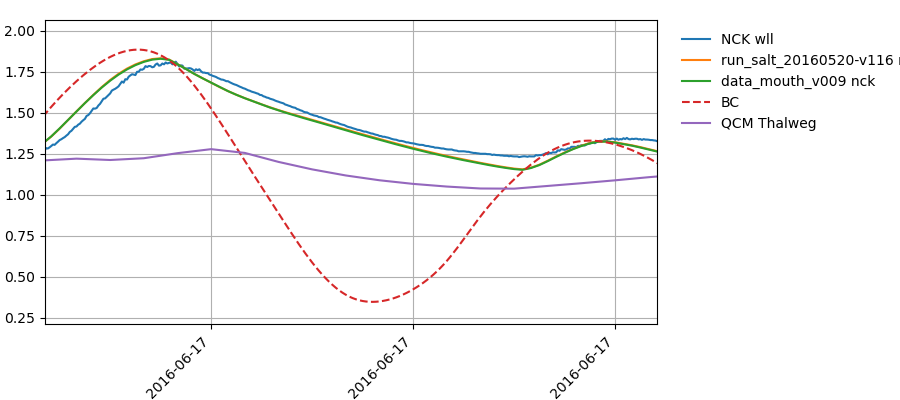

/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(16969.044347661897,
 16969.801914782973,
 0.21143524775386066,
 2.0655442341305115)

In [10]:
import six
six.moves.reload_module(dc)

sources=[observed]

for model in models: # Model outputs:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None,
                                 offset_source=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207,0,2])

plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

ax.lines[-1].set_linestyle('--')

if 1: # Add in QCM time series
    #ax.plot(qcm.time,qcm.z_ocean,label='QCM Ocean (adj)')
    #ax.plot(qcm.time,qcm.z_ocean_orig,label='QCM Ocean (orig)')
    #ax.plot(qcm.time,qcm['Modeled Lagoon Level (feet NAVD88)']*0.3048,
    #        label='QCM Model Lagoon')
    ax.plot(qcm.time,qcm['z_thalweg'],label='QCM Thalweg')

fig.set_size_inches([9,4],forward=True)
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1], frameon=0)
ax.set_position([0.05,0.19,0.68,0.76])

ax.axis( xmin=his_ds.time.values[0]-np.timedelta64(1,'h'),
         xmax=his_ds.time.values[-1]+np.timedelta64(1,'h'))


ax.axis((16969.044347661897, 16969.801914782973, 0.21143524775386066, 2.0655442341305115))


In [11]:
# Compare observed lagoon level from QCM and BML 
# This just to establish the offset (which is applied
# above)
if 0:
    qcm['z_lagoon']=qcm['Observed Lagoon Level (feet NAVD88)']*0.3048
    ds_qcm_lagoon=xr.Dataset.from_dataframe(qcm.set_index('time'))['z_lagoon']
    dc.calibration_figure_3panel([ds_qcm_lagoon,observed],trim_time=True,offset_source=None) ;

Salinity Comparisons
--

In [12]:
def load_bml(fname):
    df=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/"+fname)
    # UTC
    df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
    # some stations have some bad, -99 values
    df.loc[df.salinity<0,'salinity']=np.nan
    missing=df.time.isnull()
    df=df[~missing]
    df.set_index('time',inplace=True)
    return df

bml_nck_sfc_mcat=load_bml("NCK_sfc_mcat_concatenated.csv")
bml_nck_btm_mcat=load_bml("NCK_btm_mcat_concatenated.csv")
bml_pc3_sfc_sond=load_bml("PC3_sfc_sonde_concatenated.csv")
bml_pc3_btm_sond=load_bml("PC3_btm_sonde_concatenated.csv")

bml_bc1_btm_sond=load_bml("BC1_btm_sonde_concatenated.csv")
bml_bc1_sfc_sond=load_bml("BC1_sfc_sonde_concatenated.csv")

bml_bc3_btm_mcat=load_bml("BC3_btm_mcat_concatenated.csv")
bml_bc3_sfc_mcat=load_bml("BC3_sfc_mcat_concatenated.csv")

bml_ch2_btm_mcat=load_bml("CH2_btm_mcat_concatenated.csv")
bml_ch2_sfc_mcat=load_bml("CH2_sfc_mcat_concatenated.csv")

    

In [22]:
def surface(da):
    # assume data array is {cell or time},layer
    scal=da.values
    valid=np.isfinite(scal)

    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    return np.choose(surf_idxs,scal.T)

def bottom(da):
    # assumes data array is time,layer
    scal=da.values
    valid=np.isfinite(scal)
    bed_idxs=np.argmax(valid,axis=1)
    return np.choose(bed_idxs,scal.T) 
    
class FigSalt:
    zoom=(16960.24667031317,
          16962.483944929114,
           -0.5475896244306924,
           36.366318197905606)
    layers=['surface','bottom'] # bed layer, and near-surface layer that is mostly wet.
    layer_styles=['-','--']
    colors=['tab:blue','tab:orange','tab:green','tab:red','tab:brown','tab:purple']
    def load(self,run_dirs,station_name):
        das=[]
        for run_dir in run_dirs:
            his_fn=os.path.join(run_dir,'DFM_OUTPUT_flowfm','flowfm_0000_his.nc')
            ds=xr.open_dataset(his_fn)
            stn=np.nonzero( ds.station_name.values==station_name )[0][0]
            da=ds['salinity'].isel(stations=stn)
            da.attrs['label']=run_dir
            das.append(da)
        return das

    def __init__(self,run_dirs,his_name,bml_sfc,bml_btm,**kws):
        self.fig_dir=os.path.join(run_dirs[0],'fig')
        utils.set_keywords(self,kws)
    
        self.das=self.load(run_dirs,his_name)
        self.his_name=his_name
        
        fig,ax=plt.subplots(figsize=(8,4.5))
        self.fig=fig
        self.ax=ax

        for color,stn_da in zip(self.colors[1:],self.das):
            # Pick out top/bottom finite values.
            scal=stn_da.values
            da_label=stn_da.attrs['label']

            valid=np.isfinite(scal) # time,layer

            for ls,lay in zip(self.layer_styles,self.layers):
                if lay=='surface':
                    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
                    #lay_scal=np.choose(surf_idxs,scal.T)
                    # np.choose has an upper bound of 32 choices!
                    lay_scal=np.array([scal[ti,li] for ti,li in enumerate(surf_idxs)])
                    z_label="Surface"
                elif lay=='bottom':
                    bed_idxs=np.argmax(valid,axis=1)
                    #lay_scal=np.choose(bed_idxs,scal.T) 
                    lay_scal=np.array( [scal[ti,li] for ti,li in enumerate(bed_idxs)])
                    z_label="Bottom"
                else:
                    lay_scal=scal[:,lay]
                    z=stn_da.zcoordinate_c.isel(laydim=lay).mean().values
                    z_label=f"z={z:.2f} m"
                ax.plot(stn_da.time, lay_scal,
                        label=f"{da_label}\n{z_label}", color=color, ls=ls)
            # Nan transitions:
            bad_salt=np.nonzero(np.diff(np.isnan(lay_scal))>0)[0]
            ax.plot(stn_da.time.values[1:][bad_salt],
                    0*bad_salt,'kx')
            
        # BML Data
        for ls,lay in zip(self.layer_styles,self.layers):
            if lay=='surface':
                ax.plot(bml_sfc.index.values, bml_sfc.salinity,
                        color=self.colors[0],ls=ls,label="BML surface")
            elif lay=='bottom':
                ax.plot(bml_btm.index.values, bml_btm.salinity, 
                        color=self.colors[0],ls=ls,label="BML bottom")
            else:
                print(f"No bml data for layer={lay}")

        ax.legend(loc='upper left',bbox_to_anchor=[1.01,1.0])
        fig.subplots_adjust(right=0.7)
        fig.autofmt_xdate()
        ax.axis( self.zoom )
        name=his_name.decode()
        ax.text(0.03,0.98,name.upper(),transform=ax.transAxes,va='top')
        
        self.save()
    def save(self):
        if (self.fig_dir is not None) and (not os.path.exists(self.fig_dir)):
            os.makedirs(self.fig_dir)
        self.fig.savefig(os.path.join(self.fig_dir,f"salt-timeseries-{self.his_name}.png"))
        

<IPython.core.display.Javascript object>


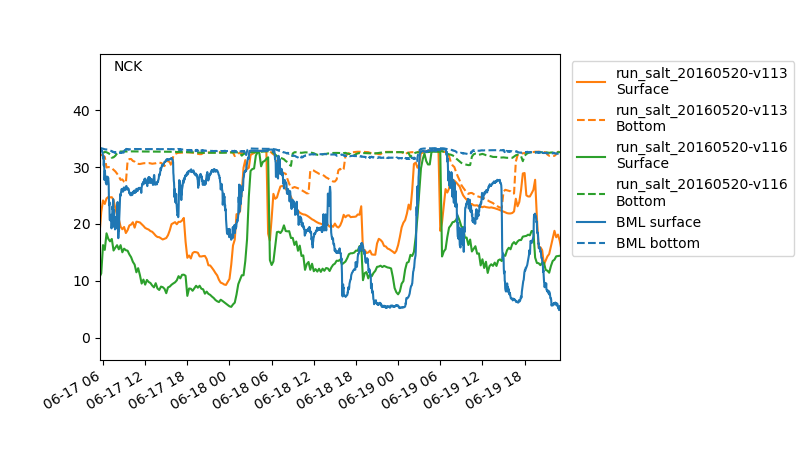

<IPython.core.display.Javascript object>


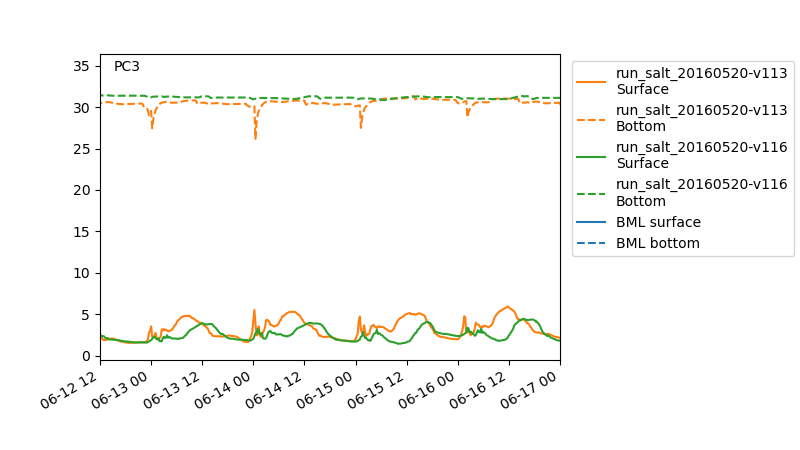

<IPython.core.display.Javascript object>


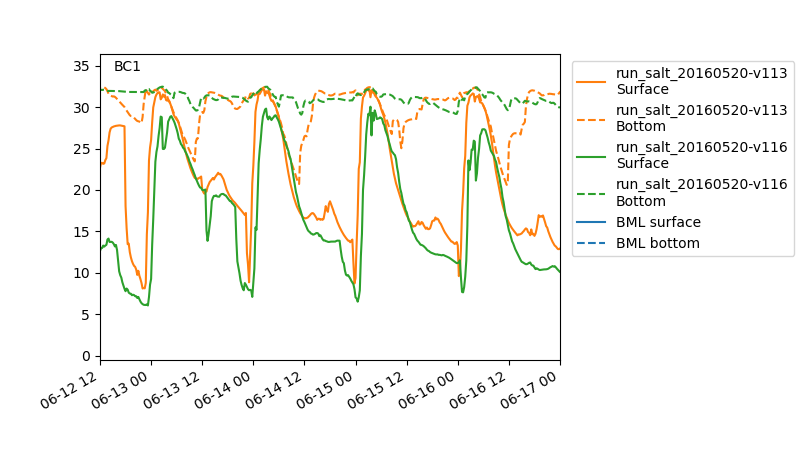

<IPython.core.display.Javascript object>


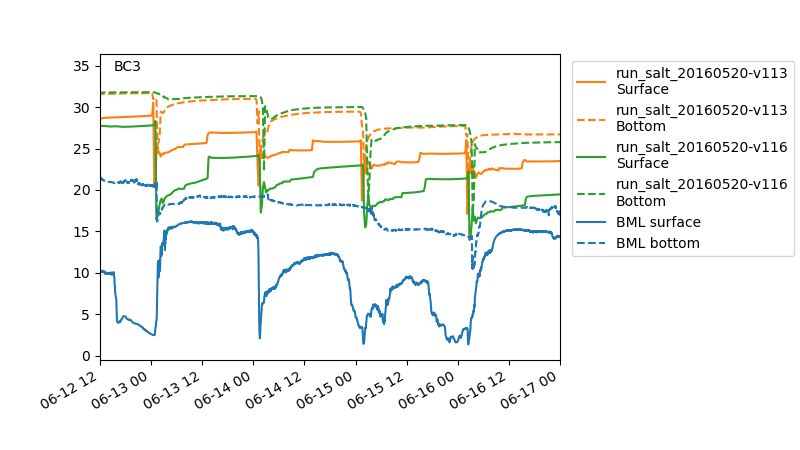

<IPython.core.display.Javascript object>


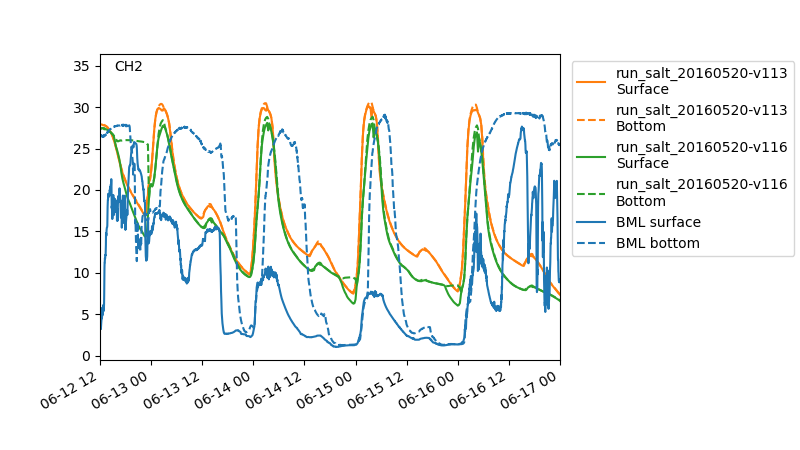

(16964.5, 16969.0, -0.5, 36.4)

In [25]:
#run_dir="run_salt_20160520-v93"
run_dirs=["run_salt_20160520-v113",
          "run_salt_20160520-v116"]

kws=dict(zoom=(16964.5, 16969.0, -0.5, 36.4))
         
FigSalt(run_dirs,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat,**kws)
plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

FigSalt(run_dirs,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond,**kws)
plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

FigSalt(run_dirs,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond,**kws)
plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

FigSalt(run_dirs,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat,**kws)
plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

FigSalt(run_dirs,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat,**kws)
plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

In [582]:
six.moves.reload_module(multi_ugrid)
mu=multi_ugrid.MultiUgrid(f"{run_dir}/DFM_OUTPUT_flowfm/*_map.nc",
                         cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [602]:
t_start_s=(np.datetime64("2016-06-22T00:00") - mu.time.values[0]) / np.timedelta64(1,'s')
t_start_s, t_start_s+86400*2

(1036800.0, 1209600.0)

In [626]:
fig_dir="figs-20210611"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

<IPython.core.display.Javascript object>


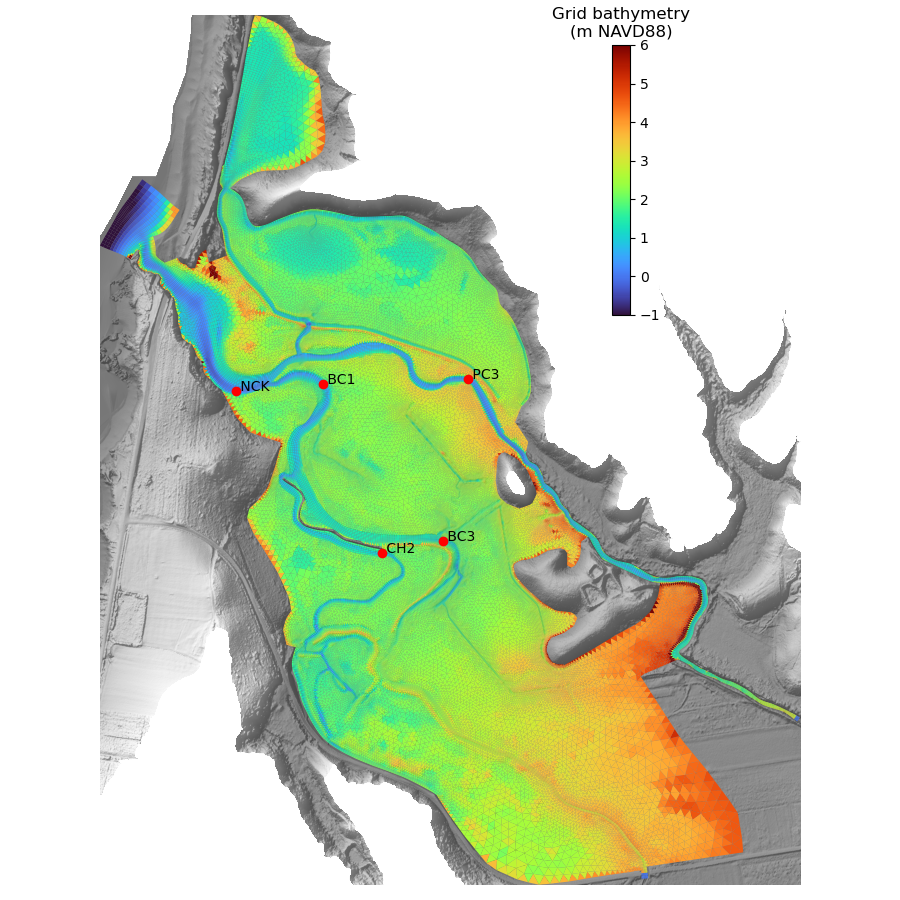

In [627]:
# Make a nice grid/bathy/station figure
from stompy.spatial import field
fig,ax=plt.subplots(1,1,figsize=(9,9))

#zoom=(551932.9888888889, 553361.1838709676, 4123382.36344086, 4125404.205734767)
zoom=mu.grid.bounds()

dem=field.GdalGrid("../../bathy/compiled-dem-existing-20210608-1m.tif")

dem.crop(zoom).plot(ax=ax,cmap='gray',alpha=0.5)
# could put the hillshade above the grid, but it's misleading
dem.crop(zoom).plot_hillshade(ax=ax,plot_args=dict(alpha=0.5))
ccoll=mu.grid.plot_cells(values=mu['mesh2d_flowelem_bl'].values,cmap='turbo',ax=ax,
                         clim=[-1,6])

for stn in ['nck','pc3','bc1','BC3','ch2']:
    stn_idx=list(his_ds.station_name.values).index(stn.encode())
    stn_ds=his_ds.isel(stations=stn_idx)
    x=stn_ds.station_x_coordinate
    y=stn_ds.station_y_coordinate
    
    ax.text(x,y," "+stn.upper())
    ax.plot([x],[y],'ro')
    
ax.axis('off')
fig.tight_layout()

cax=fig.add_axes([0.68,0.65,0.02,0.30])
plt.colorbar(ccoll,cax=cax)
cax.set_title('Grid bathymetry\n(m NAVD88)')

fig.savefig(fig_dir+"/grid-stations-bathy.png",dpi=150)

In [624]:
ccoll.set_clim([-1,6])

In [604]:
mu.dss[0]

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 9154, mesh2d_nFaces: 5705, mesh2d_nInterfaces: 29, mesh2d_nLayers: 28, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3450, time: 19)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.526e+05 ... 5.53e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.123e+06 ... 4.124e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 5.526e+05 ... 5.531e+05
    mesh2d_edge_y                (mesh2d_nEdges) float64 4.123e+06 ... 4.124e+06
    mesh2d_face_x                (mesh2d_nFaces) float64 5.526e+05 ... 5.531e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.123e+06 ... 4.124e+06
  * time                         (time) datetime64[ns] 2016-06-10 ... 2016-06-28
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nInterfaces, mesh2d_nLayers, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 -2147483647
    mesh2d                       int32 -2147483647
    mesh2d_node_z                (mesh2d_nNodes) float64 1.659 1.635 ... 2.219
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 1 2 3 ... 3440 3439
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_edge_faces            (mesh2d_nEdges, Two) float64 1.0 2.0 ... 0.0
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_layer_z               (mesh2d_nLayers) float64 -0.1875 ... 3.188
    mesh2d_interface_z           (mesh2d_nInterfaces) float64 -0.25 ... 3.25
    mesh2d_edge_type             (mesh2d_nEdges) float64 1.0 1.0 1.0 ... 3.0 3.0
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 21.54 22.08 ... 22.51
    mesh2d_flowelem_bl           (mesh2d_nFaces) float64 1.659 1.275 ... 2.214
    mesh2d_flowelem_domain       (mesh2d_nFaces) float64 5.0 5.0 5.0 ... 7.0 7.0
    mesh2d_flowelem_globalnr     (mesh2d_nFaces) float64 6.251e+04 ... 5.284e+04
    timestep                     (time) float64 1.0 0.9346 ... 0.7444 1.695
    mesh2d_Numlimdt              (time, mesh2d_nFaces) float64 ...
    mesh2d_waterdepth            (time, mesh2d_nFaces) float64 0.0 ... 0.0
    mesh2d_s1                    (time, mesh2d_nFaces) float64 ...
    mesh2d_u1                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_u0                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_ucx                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucy                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucz                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucxa                  (time, mesh2d_nFaces) float64 ...
    mesh2d_ucya                  (time, mesh2d_nFaces) float64 ...
    mesh2d_ucmag                 (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucmaga                (time, mesh2d_nFaces) float64 ...
    mesh2d_ww1                   (time, mesh2d_nFaces, mesh2d_nInterfaces) float64 ...
    mesh2d_rho                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_q1                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_viu                   (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_diu                   (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 ...
    mesh2d_sa1                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_tem1                  (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_turkin1               (time, mesh2d_nEdges, mesh2d_nInterfaces) float64 ...
    mesh2d_vicwwu                (time, mesh2d_nEdges, mesh2d_nInterfaces) float64 ...
    mesh2d_tureps1               (ti

<IPython.core.display.Javascript object>


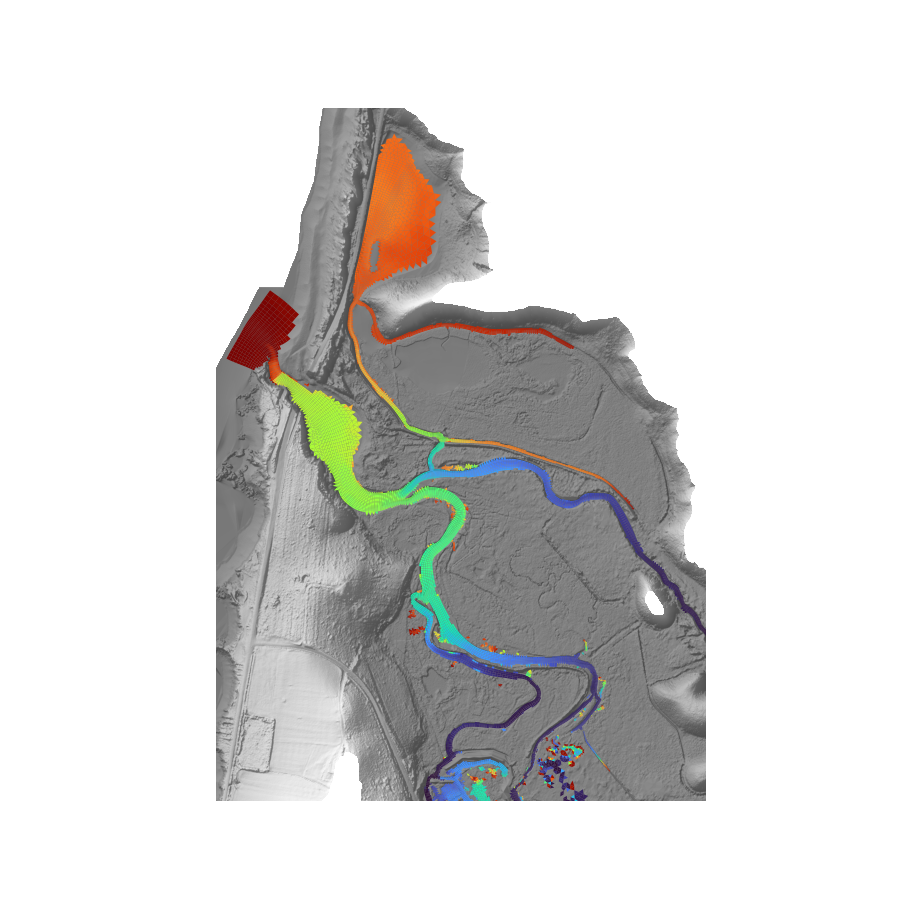

(551932.9888888889, 553361.1838709676, 4123382.36344086, 4125404.205734767)

In [595]:
snap=mu.isel(time=16)

# Find a nice salinity snapshot for a restart to make an animation
mu.grid.plot_cells(values=surface(snap['mesh2d_sa1']),
                   mask=snap['mesh2d_waterdepth'].values>0.01,
                   cmap='turbo',clim=[0,33])

ax.axis(zoom)
ax.axis('off')

In [594]:
snap.time

MultiVar wrapper around <xarray.DataArray 'time' ()>
array('2016-06-25T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-06-25
Attributes:
    standard_name:  time

Compare BCs
--

Seem to be fine


In [341]:
bcs=model.load_bcs()
bc_names=[bc['name'] for bc in bcs]
pesca_ck_bc=bcs[bc_names.index('pescadero_ck')]
butano_ck_bc=bcs[bc_names.index('butano_ck')]

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [342]:
# USGS gauge: 11162500
from stompy.io.local import usgs_nwis

da=pesca_ck_bc['data']
pesca_usgs=usgs_nwis.nwis_dataset(11162500,start_date=da.time.values[0],
                                  end_date=da.time.values[-1],
                                  products=[60])

INFO:usgs_nwis:Fetching 11162500_60_2016-07-01_2016-08-01.nc


In [343]:
his_ds.close()
his_ds=xr.open_dataset(model.his_output())

In [344]:
his_ds.cross_section_name

<xarray.DataArray 'cross_section_name' (cross_section: 10)>
array([b'mouth_xs', b'n_pond_xs', b'n_ditch_xs', b'n_complex_xs',
       b'pesca_mid_xs', b'butano_lower_xs', b'pesca_lower_xs', b'pesca_bc_xs',
       b'butano_bc_xs', b'butano_mid_xs'], dtype='|S64')
Coordinates:
    cross_section_name  (cross_section) |S64 b'mouth_xs' ... b'butano_mid_xs'
Dimensions without coordinates: cross_section
Attributes:
    cf_role:    timeseries_id
    long_name:  cross section name

In [364]:
from stompy import filters 

In [363]:
his_ds['cross_section_discharge'].isel(cross_section=0).mean()

<xarray.DataArray 'cross_section_discharge' ()>
array(-0.11390233)
Coordinates:
    cross_section_name  |S64 b'mouth_xs'

In [367]:
np.median(np.diff(his_ds.time.values))/np.timedelta64(60,'s')

5.0

<IPython.core.display.Javascript object>


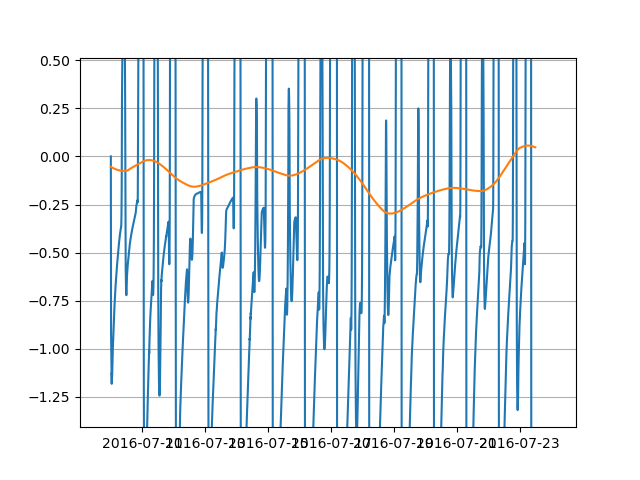

In [368]:
plt.figure()

plt.plot(his_ds.time, his_ds['cross_section_discharge'].isel(cross_section=0) )
plt.plot(his_ds.time, 
         filters.lowpass_godin(his_ds['cross_section_discharge'].isel(cross_section=0).values,
                               mean_dt_h=5./60))


<IPython.core.display.Javascript object>


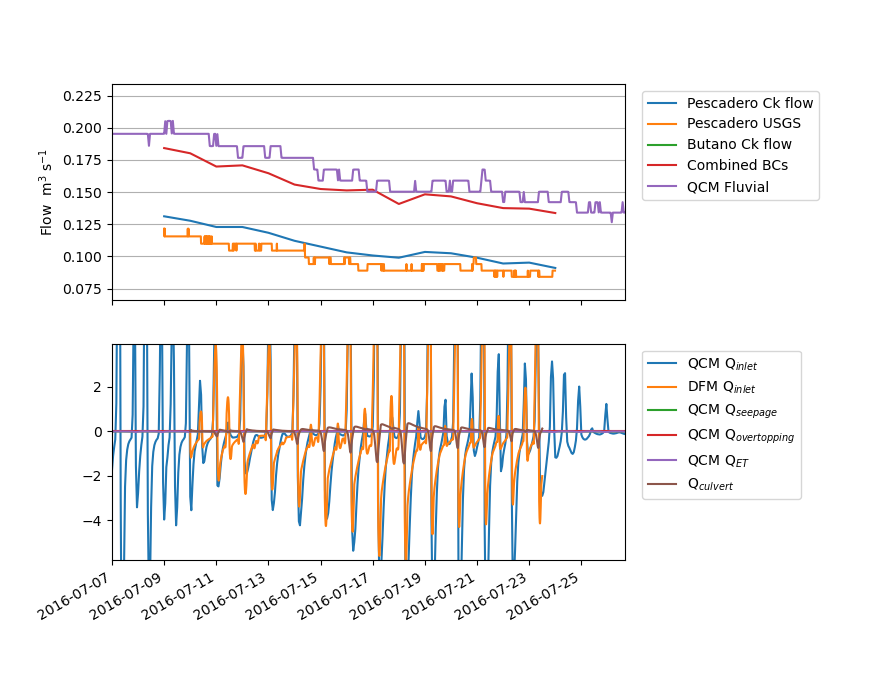

In [354]:
mouth=his_ds.isel(cross_section=0)
fig,(ax,ax_other)=plt.subplots(2,1,sharex=True)

Q=pesca_ck_bc['data']
ax.plot(Q.time, Q.flow, label="Pescadero Ck flow")

ax.plot(pesca_usgs.time,
        pesca_usgs.stream_flow_mean_daily * 0.3048**3,
        label='Pescadero USGS')

Q=butano_ck_bc['data']
ax.plot(Q.time, Q.flow, label="Butano Ck flow")

Q_comb=butano_ck_bc['data'].flow + pesca_ck_bc['data'].flow
ax.plot(Q_comb.time, Q_comb, label="Combined BCs")

ax.plot(qcm.time, qcm['combined fluvial'] * 0.3048**3,label='QCM Fluvial')
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1])

fig.subplots_adjust(right=0.70)

ax.set_ylabel('Flow  m$^3$ s$^{-1}$')
ax.axis(xmin=da.time.values[0],xmax=da.time.values[-1],ymin=-0.05,ymax=0.65)

# And other fluxes:
ax_other.plot(qcm.time, qcm['Modeled inlet flow'] * 0.3048**3,label='QCM Q$_{inlet}$')
ax_other.plot(mouth.time, mouth['cross_section_discharge'],label="DFM Q$_{inlet}$" )

ax_other.plot(qcm.time, qcm['Modeled seepage'] * 0.3048**3,label='QCM Q$_{seepage}$')
ax_other.plot(qcm.time, qcm['Modeled wave overtopping'] * 0.3048**3,label='QCM Q$_{overtopping}$')
ax_other.plot(qcm.time, qcm['Modeled ET'] * 0.3048**3,label='QCM Q$_{ET}$')

ax_other.plot( his_ds.time, his_ds['gategen_discharge'].isel(gategens=0),
              label='Q$_{culvert}$')

ax_other.legend(loc='upper left',bbox_to_anchor=[1.02,1])
ax_other.axis(ymin=-40,ymax=40)

fig.autofmt_xdate()

<IPython.core.display.Javascript object>


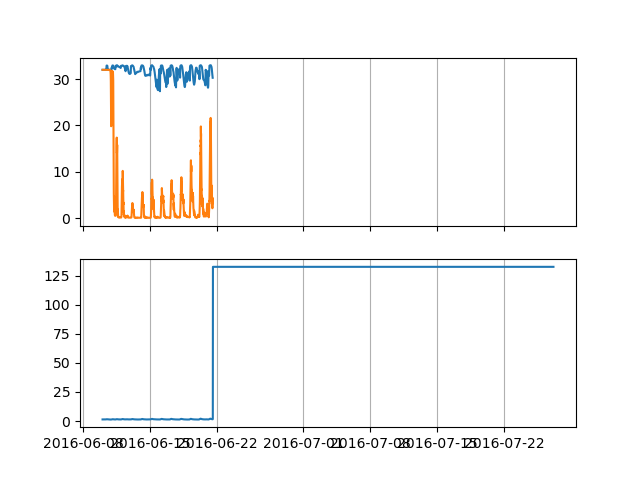

In [499]:
stn_ds=his_ds.isel(stations=7) # nck

#valid=np.any( np.isfinite(stn_ds.salinity.values),axis=1)
#salt_crash=np.nonzero( ~valid )[0][0]
#salt_crash # 3317

#eta_crash=np.nonzero( np.isnan())
#stn_ds.salinity.isel(time=-1)

fig,axs=plt.subplots(2,1,sharex=True)
axs[0].plot( stn_ds.time, bottom(stn_ds.salinity))
axs[0].plot( stn_ds.time, surface(stn_ds.salinity))
axs[1].plot( stn_ds.time, stn_ds.waterlevel)

In [451]:
versions=["v83","v84"]

his_fns=[f"run_salt_20160520-{ver}/DFM_OUTPUT_flowfm/flowfm_0000_his.nc"
         for ver in versions]
try:
    [ds.close() for ds in hiss]
except NameError:
    pass

#his_fns.append(f"run_salt_20160520-v76/DFM_OUTPUT_flowfm/flowfm_his.nc")
#versions.append('v76')

hiss=[]
for fn in his_fns:
    try:
        ds=xr.open_dataset(fn)
    except OverflowError:
        # workaround -- some sort of issue with the timestamps in 
        # this one.
        ds=xr.open_dataset(fn,decode_times=False)
        ds['time']=ds.time.astype(np.int64)
        ds=xr.decode_cf(ds)
    hiss.append(ds)


ncks=[ his.isel(stations=7) for his in hiss]

<IPython.core.display.Javascript object>


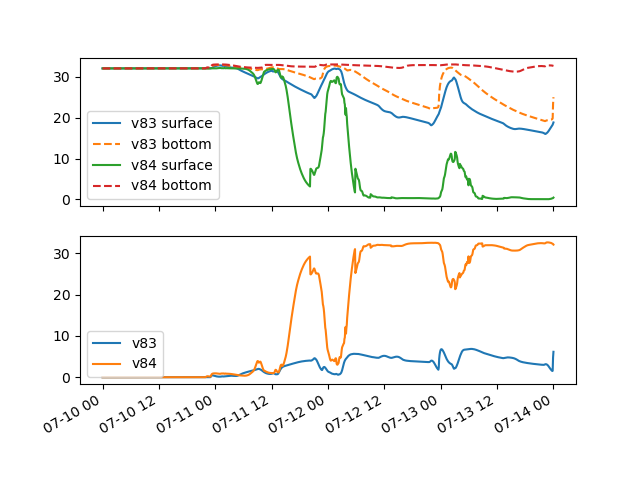

In [452]:
fig,axs=plt.subplots(2,1,sharex=True)

for ver,nck in zip(versions,ncks):
    surf=surface(nck['salinity'])
    bott=bottom(nck['salinity'])
    axs[0].plot(nck.time, surf, label=ver+' surface')
    axs[0].plot(nck.time, bott, label=ver+' bottom',ls='--')
    axs[1].plot(nck.time, bott-surf, label=ver)

axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')
fig.autofmt_xdate()

<IPython.core.display.Javascript object>


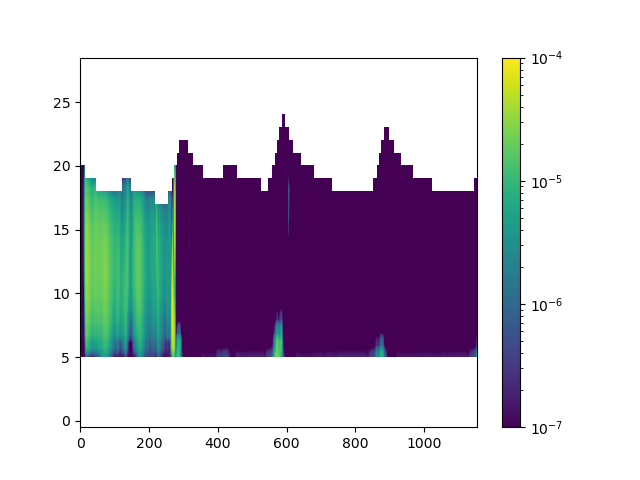

In [458]:
plt.figure()
from matplotlib import colors

img=plt.imshow( ncks[0].vicww.values.T, aspect='auto',origin='lower',
                norm=colors.LogNorm(vmin=1e-7,vmax=1e-4))
plt.colorbar(img)

In [448]:
# did I manage to actually more layers in v83?
for nck in [ncks[0],ncks[2]]:
    display(nck['salinity'].isel(time=1000))
    

<xarray.DataArray 'salinity' (laydim: 28)>
array([      nan,       nan,       nan, 24.645521, 24.384358, 23.829141,
       23.112437, 22.296463, 21.476686, 20.760543, 20.152692, 19.671831,
       19.512516,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan])
Coordinates:
    station_x_coordinate  float64 ...
    station_y_coordinate  float64 ...
    station_name          |S64 ...
    zcoordinate_c         (laydim) float64 ...
    time                  datetime64[ns] 2016-07-13T11:20:00
Dimensions without coordinates: laydim
Attributes:
    units:          1e-3
    geometry:       station_geom
    standard_name:  salinity

<xarray.DataArray 'salinity' (laydim: 28)>
array([      nan,       nan,       nan,       nan, 24.589791, 24.521371,
       24.368578, 24.114651, 23.74893 , 23.310877, 22.83799 , 22.336252,
       21.816276, 21.304201, 20.833517, 20.425156, 20.065017, 19.758565,
       19.53525 , 19.474027,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan])
Coordinates:
    station_x_coordinate  float64 5.524e+05
    station_y_coordinate  float64 4.124e+06
    station_name          |S64 b'nck'
    zcoordinate_c         (laydim) float64 nan nan nan nan ... nan nan nan nan
    time                  datetime64[ns] 2016-07-13T11:20:00
Dimensions without coordinates: laydim
Attributes:
    units:          1e-3
    geometry:       station_geom
    standard_name:  salinity

<IPython.core.display.Javascript object>


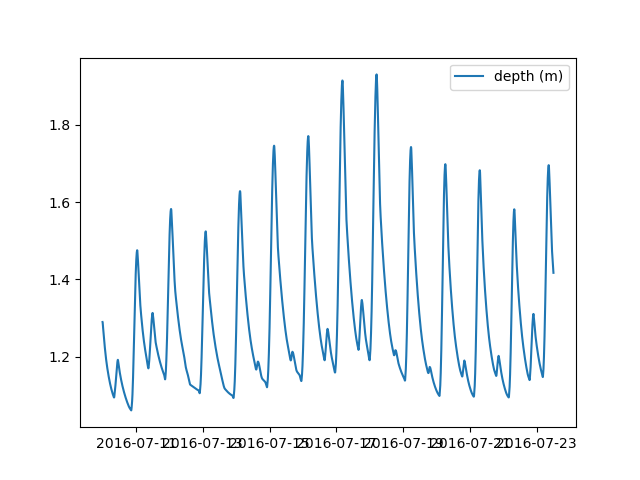

In [429]:
plt.figure()
plt.plot(ncks[0].time,
         ncks[0].waterlevel- ncks[0].bedlevel,
         label='depth (m)')
plt.legend()